In [166]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins, utils
#mpld3.enable_notebook()

In [168]:
#code for making artificial dataset
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGU', motives=None, motif_length=6, 
                            sequence_length=100, n_sequences=1000, n_motives=2, p=0.2,
                           random_state=1):
    random.seed(random_state)
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
    
    sequence_length = sequence_length / len(motives)
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences

    counter=0
    seqs=[]
    for i in range(n_seq_per_motif):
        total_seq = ''
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            total_seq += seq
        seqs.append(('>ID%d'%counter,total_seq))
        counter += 1
    return motives, seqs

In [169]:
def flatten(graphs_list):
    for graphs in graphs_list:
        for graph in graphs:
            yield graph

# Experimental Setup

In [170]:
#setup parameters
alphabet='ACGU'
semi_len=7
motives=['A'*semi_len+'C'*semi_len,
         'U'*semi_len+'G'*semi_len]
sequence_length=60
n_sequences=800
p=0.1

#make dataset
motives, seqs = make_artificial_dataset(alphabet=alphabet,
                                        motives=motives,
                                        sequence_length=sequence_length,
                                        n_sequences=n_sequences,
                                        p=p,
                                        random_state=8)

In [171]:
#display
print 'Motives and sample of their perturbed variants:'
alphabet_list=[c for c in alphabet]
for motif in motives: 
    print
    print 'true motif:', motif, ' noisy: ',
    for i in range(4):
        print perturb(motif,alphabet_list,p=p),

Motives and sample of their perturbed variants:

true motif: AAAAAAACCCCCCC  noisy:  AAAAAAACCCCCCC AAAAAAACCCCCCC AAAAAAGCUCCCCC AAAAAAACCCCCCC
true motif: UUUUUUUGGGGGGG  noisy:  UUUUCUUGGGGGAG UUUAUUUGAGGGCG AUUUUUUGGGGGGG UUUUUUUGAGGGGG


# Plan

- classify
- annotate
- decompose with max_subarray
- partition
- multiclass fit

In [172]:
opts=dict(n_graphs_per_line=3, size=25, prog='circo', 
                       vertex_border=1, vertex_size=200, colormap='Set3',
                       edge_color='_label_',edge_alpha=.3, vertex_label='label', 
                       vertex_color='_label_', ignore_for_layout='nesting')

In [173]:
from GArDen.interfaces import convert, transform, model, decompose

In [174]:
from GArDen.convert.sequence import SeqToPathGraph
graphs=transform(seqs, program=SeqToPathGraph())

In [175]:
from itertools import tee
graphs_, graphs = tee(graphs)

In [176]:
from GArDen.transform.rna_structure import RandomSequencePermutation
neg_graphs=transform(graphs_, program=RandomSequencePermutation(times=2, order=2))

In [177]:
%%time
active_graphs = graphs
inactive_graphs = neg_graphs

from eden.util import random_bipartition_iter
relative_size = 0.8
pos_train_graphs, pos_test_graphs = random_bipartition_iter(active_graphs, relative_size=relative_size, random_state=1)
neg_train_graphs, neg_test_graphs = random_bipartition_iter(inactive_graphs, relative_size=relative_size, random_state=1)

from GArDen.transform.node import AddGraphAttributeValue
pos_train_graphs = transform(pos_train_graphs, program=AddGraphAttributeValue(attribute='target', value=1))
neg_train_graphs = transform(neg_train_graphs, program=AddGraphAttributeValue(attribute='target', value=-1))
pos_test_graphs = transform(pos_test_graphs, program=AddGraphAttributeValue(attribute='target', value=1))
neg_test_graphs = transform(neg_test_graphs, program=AddGraphAttributeValue(attribute='target', value=-1))

from itertools import chain
train_graphs = list(chain(pos_train_graphs, neg_train_graphs))
test_graphs = list(chain(pos_test_graphs, neg_test_graphs))

CPU times: user 912 ms, sys: 258 ms, total: 1.17 s
Wall time: 1.08 s


In [178]:
%%time
from sklearn.linear_model import SGDClassifier
predictor = SGDClassifier()

from GArDen.model import ClassifierWrapper
wrapped_predictor = ClassifierWrapper(program=predictor)

parameters_priors=dict(average=True, loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, n_iter=5, shuffle=True, verbose=0, epsilon=0.1, n_jobs=-1, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, class_weight=None, warm_start=False)
parameters_priors.update(dict(vectorizer__r=3,vectorizer__d=5, vectorize__n_jobs=-1, vectorize__fit_flag=False, vectorize__n_blocks=5, vectorize__block_size=None))
fit_wrapped_predictor = model(train_graphs, program=wrapped_predictor, parameters_priors=parameters_priors)

CPU times: user 15.3 s, sys: 3.08 s, total: 18.4 s
Wall time: 27.7 s


In [179]:
from GArDen.transform.importance_annotation import AnnotateImportance
graphs = transform(test_graphs, program=AnnotateImportance(program=fit_wrapped_predictor.program))

In [180]:
graphs = list(graphs)

In [181]:
min_subarray_size = semi_len*2 - 4
max_subarray_size = semi_len*2 + 4

In [182]:
from GArDen.decompose.subarray import MaxSubArray
graphs_list = decompose(graphs, program=MaxSubArray(min_subarray_size=min_subarray_size, max_subarray_size=max_subarray_size))

In [183]:
# make compose
subgraphs = flatten(graphs_list)

In [184]:
from sklearn.cluster import KMeans
parameters_priors=dict(n_clusters=4, init='k-means++', n_init=10, max_iter=50, tol=0.0001, precompute_distances='auto', verbose=0, random_state=1, copy_x=True, n_jobs=-1)
clusterer = KMeans()

from sklearn.cluster import DBSCAN
parameters_priors=dict(eps=0.5, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, p=None, random_state=None)
clusterer = DBSCAN()

from GArDen.partition import ClustererWrapper
wrapped_clusterer = ClustererWrapper(program=clusterer)

In [185]:
%%time
from GArDen.interfaces import partition
parameters_priors.update(dict(vectorizer__r=2,vectorizer__d=2, vectorize__n_jobs=-1, vectorize__fit_flag=False, vectorize__n_blocks=5, vectorize__block_size=None))
partition_list = partition(subgraphs, program=wrapped_clusterer, parameters_priors=parameters_priors)

CPU times: user 1.87 s, sys: 396 ms, total: 2.27 s
Wall time: 2.51 s


Class 0


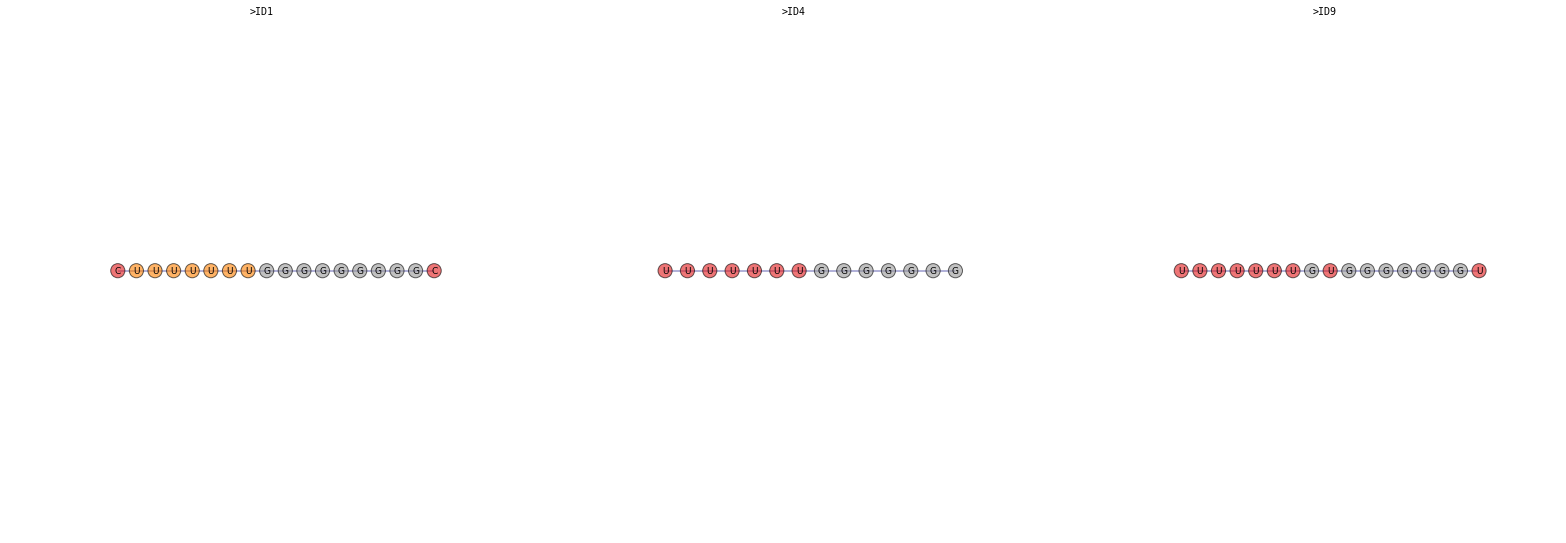

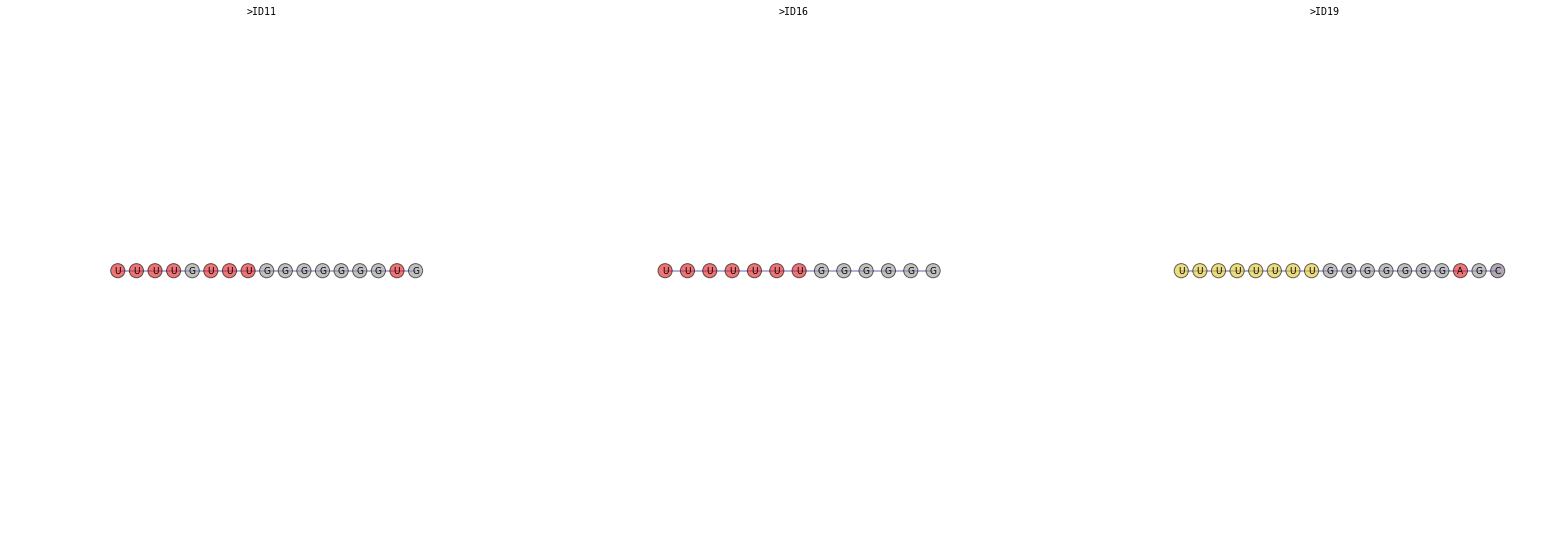

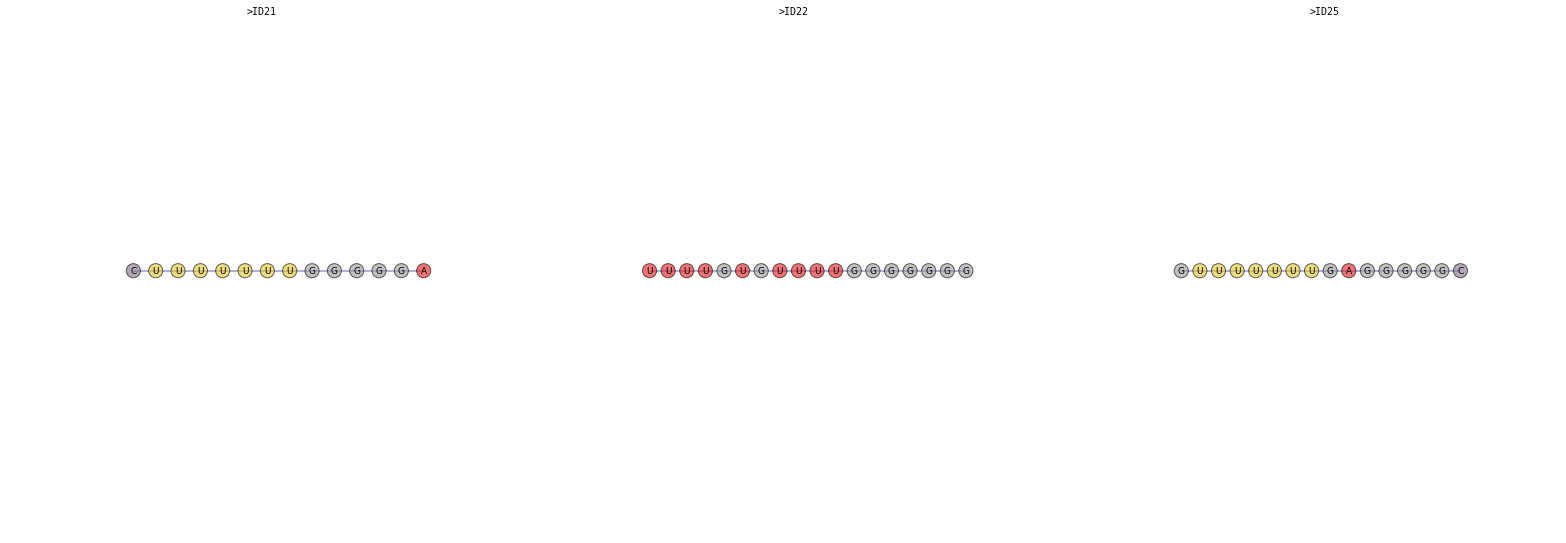

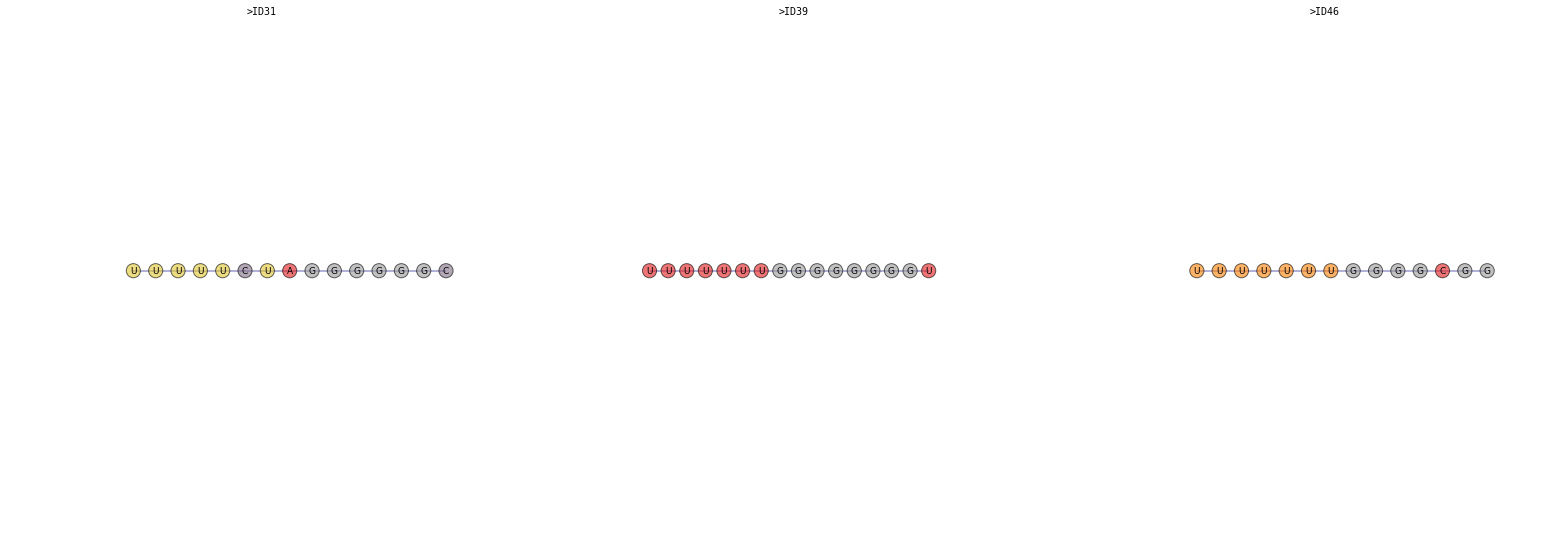

Class 1


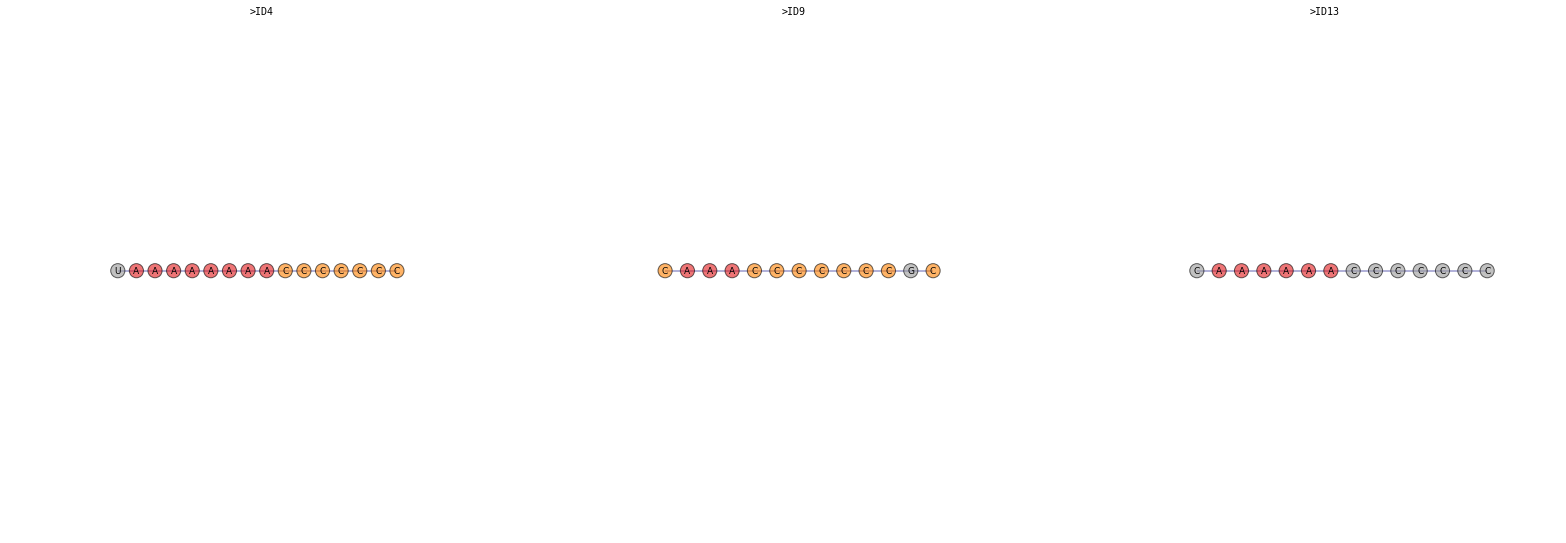

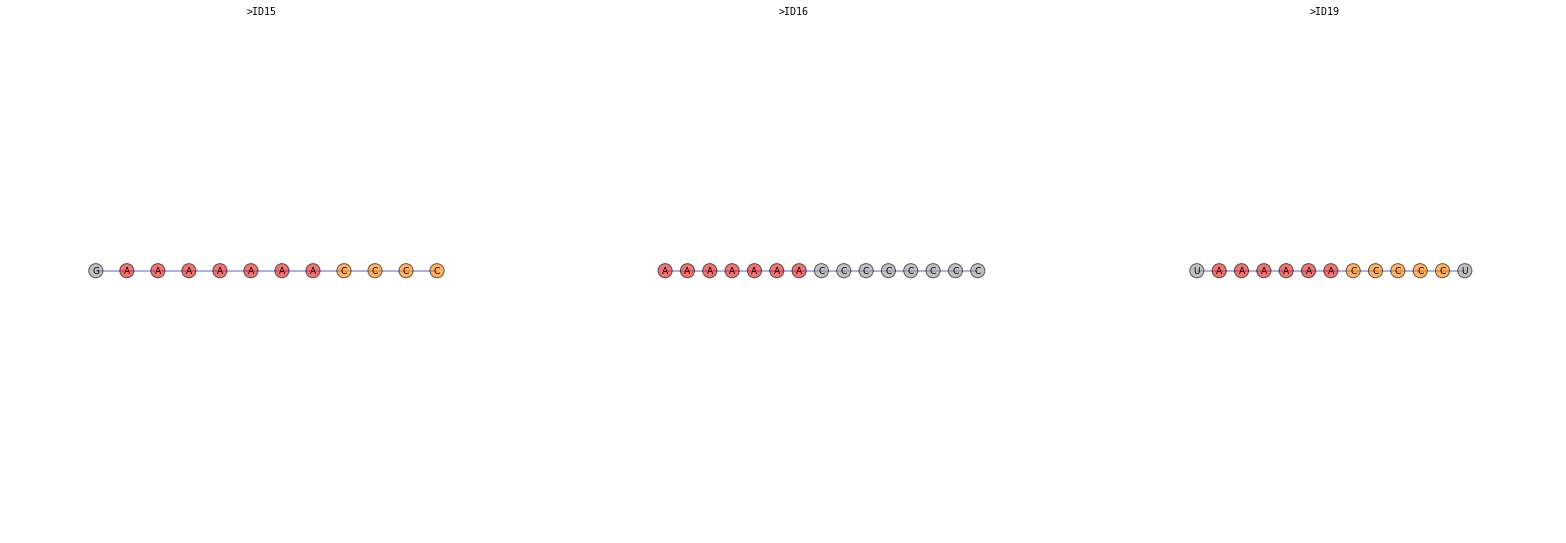

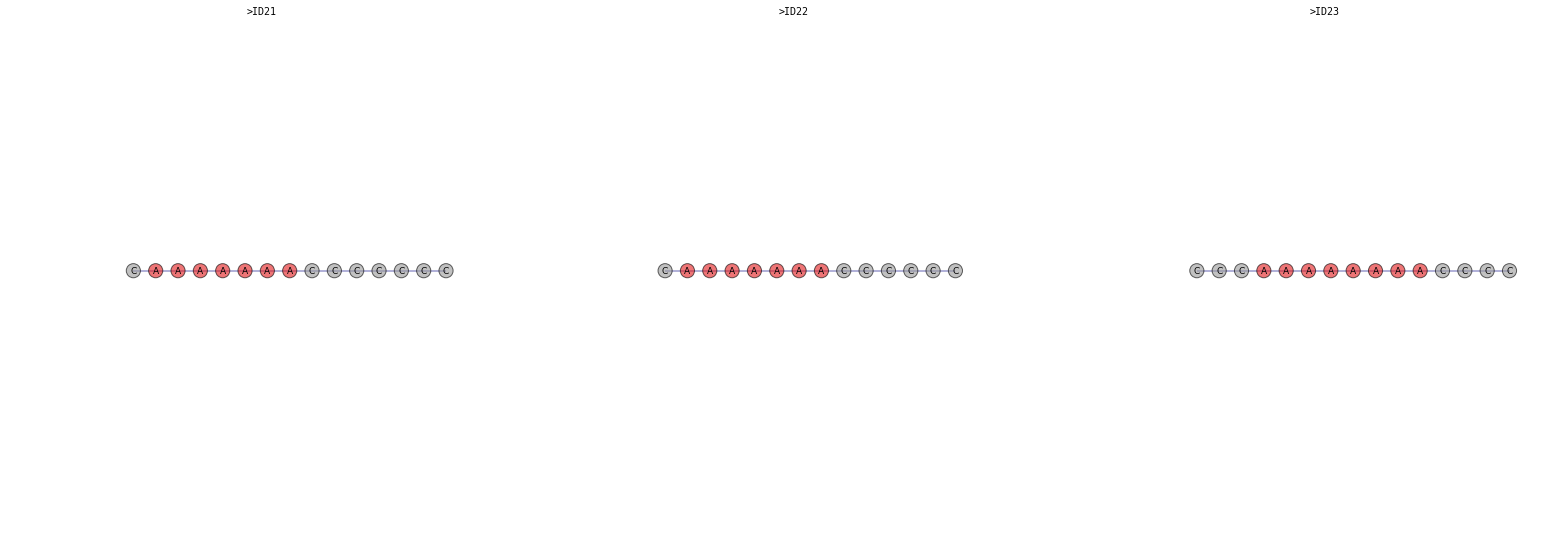

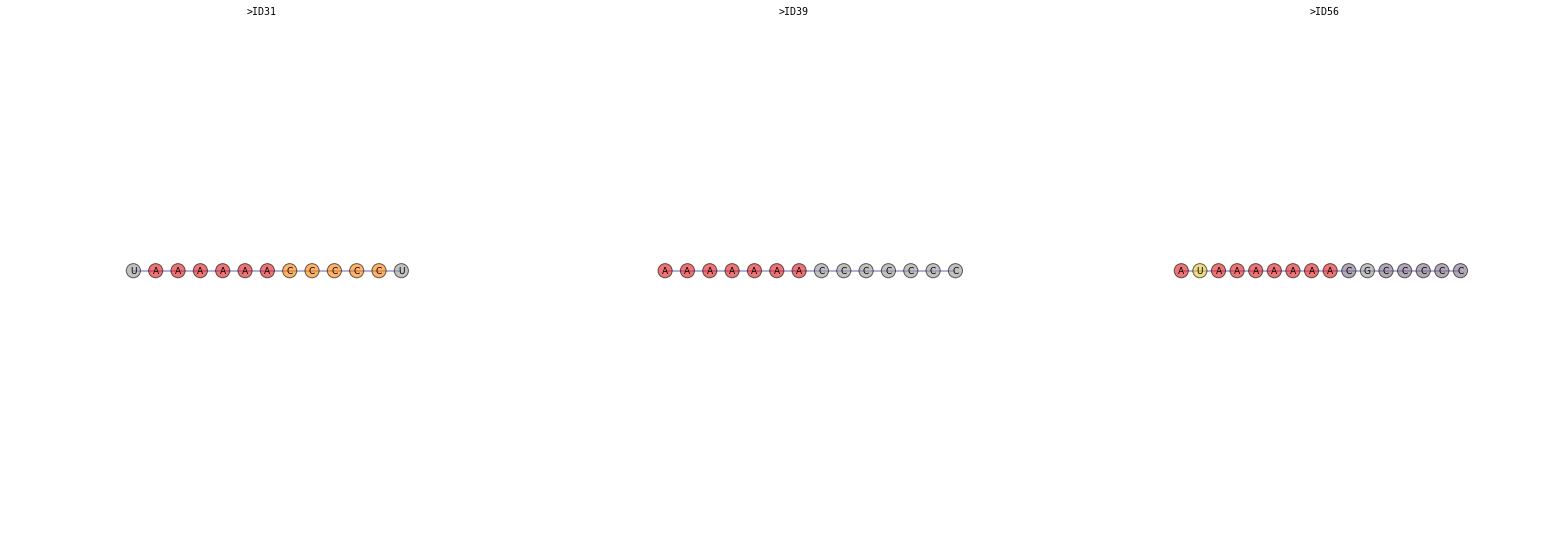

In [186]:
from itertools import islice
from eden.util.display import draw_graph_set
opts.update({'vertex_color':'_label_', 'colormap':'Set1', 'size':9})
print 'Class 0'
draw_graph_set(islice(partition_list[0],12), **opts)

print 'Class 1'
draw_graph_set(islice(partition_list[1],12), **opts)

In [187]:
from GArDen.transform.node import AddGraphAttributeValue
class_graphs_list = []
for target in partition_list:
    targeted_class_graphs = transform(partition_list[target], program=AddGraphAttributeValue(attribute='target', value=target))
    class_graphs_list.append(targeted_class_graphs)
class_graphs = flatten(class_graphs_list)

In [188]:
class_graphs=list(class_graphs)

In [189]:
%%time
from sklearn.linear_model import SGDClassifier
predictor2 = SGDClassifier()

from GArDen.model import ClassifierWrapper
wrapped_predictor2 = ClassifierWrapper(program=predictor2)

parameters_priors=dict(average=True, loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, n_iter=5, shuffle=True, verbose=0, epsilon=0.1, n_jobs=-1, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, class_weight=None, warm_start=False)
parameters_priors.update(dict(vectorizer__r=3,vectorizer__d=5, vectorize__n_jobs=-1, vectorize__fit_flag=False, vectorize__n_blocks=5, vectorize__block_size=None))
fit_wrapped_predictor2 = model(class_graphs, program=wrapped_predictor2, parameters_priors=parameters_priors)

CPU times: user 1.76 s, sys: 725 ms, total: 2.49 s
Wall time: 4.36 s


In [190]:
from GArDen.transform.importance_annotation import AnnotateImportance
fgraphs = transform(test_graphs, program=AnnotateImportance(program=fit_wrapped_predictor2.program))

In [191]:
from GArDen.transform.contraction import Contract, contraction_modifier
label_modifier = contraction_modifier(attribute_in='class', attribute_out='label', reduction='set_categorical')
modifiers = [label_modifier]
priors=dict(nesting=True,  modifiers=[modifiers], weight_scaling_factor=1)
tgraphs=transform(fgraphs, program=Contract(contraction_attribute='class'), parameters_priors=priors)

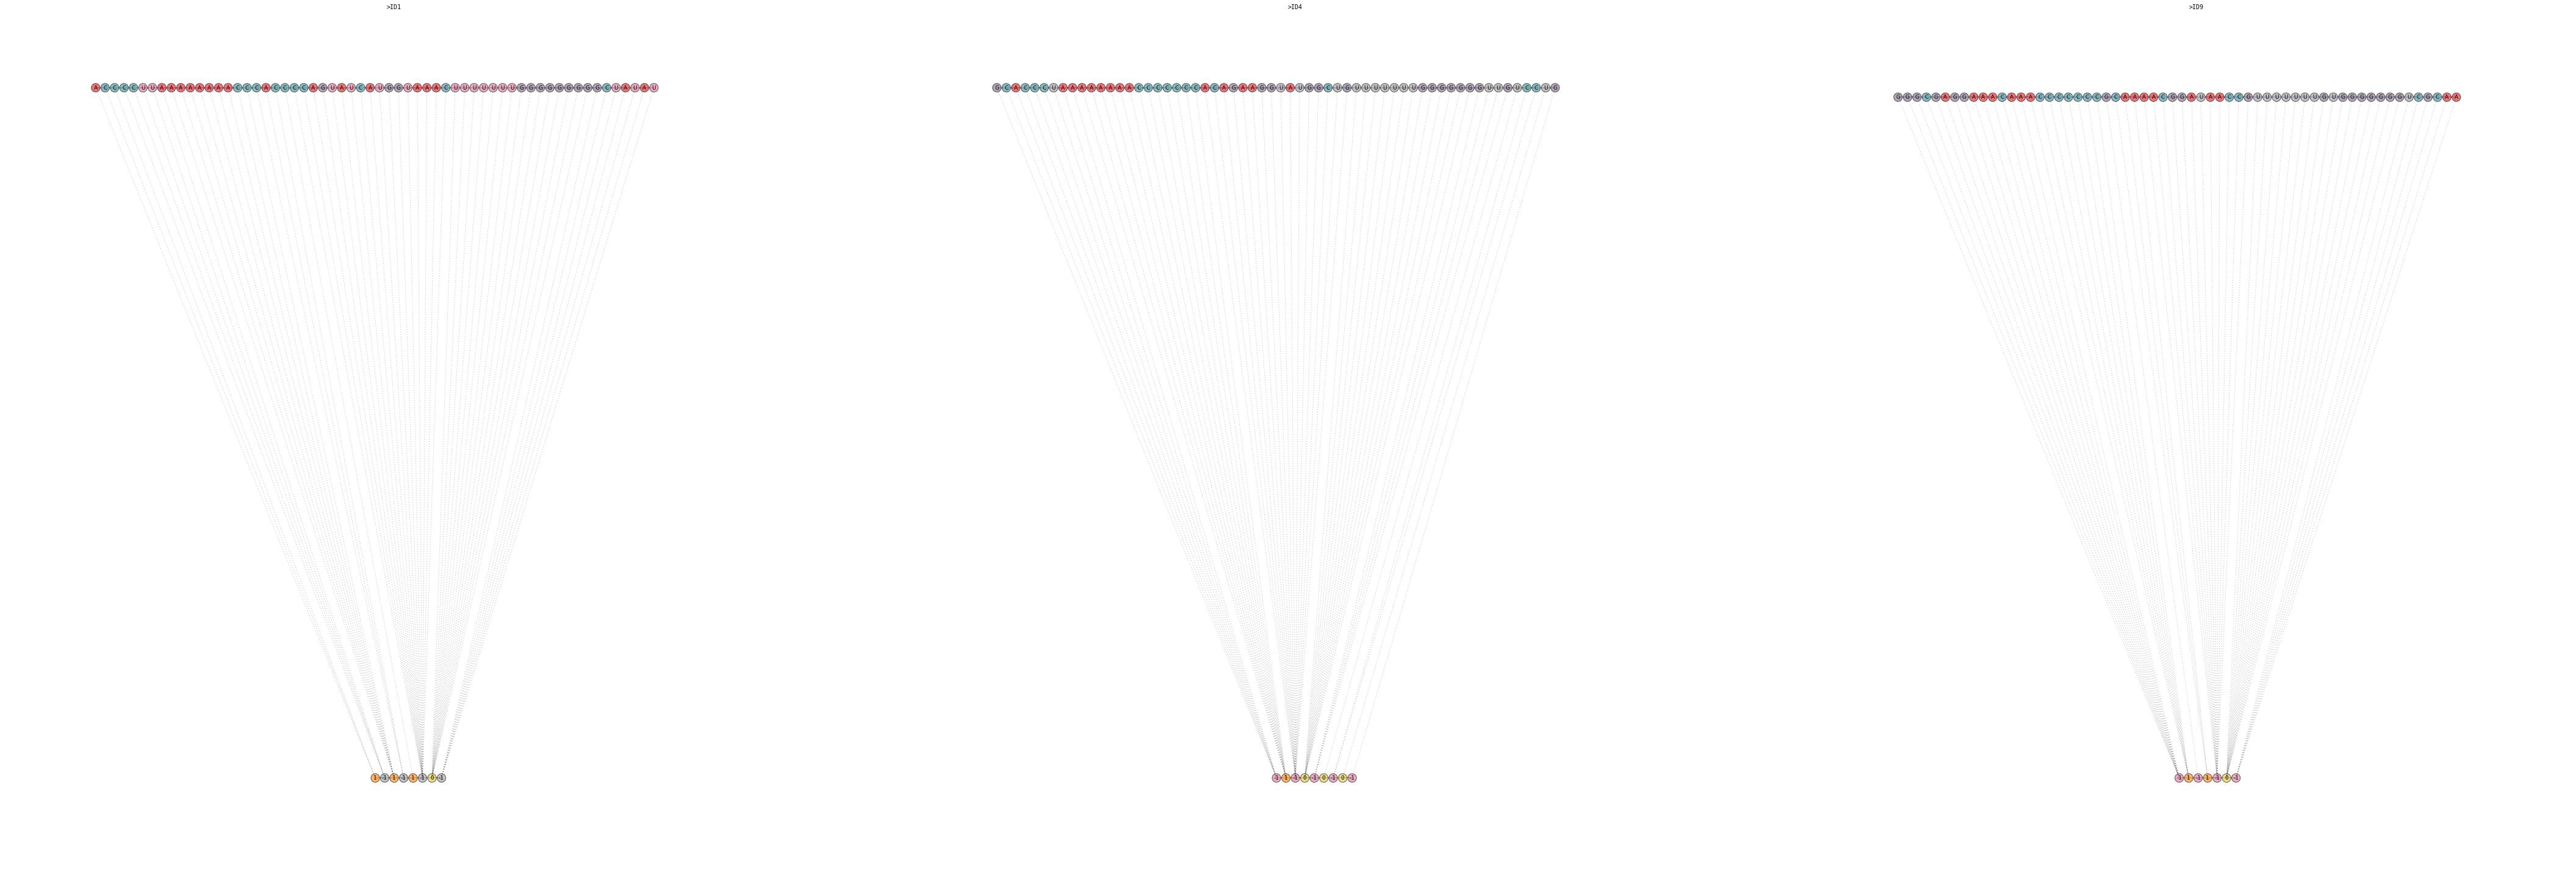

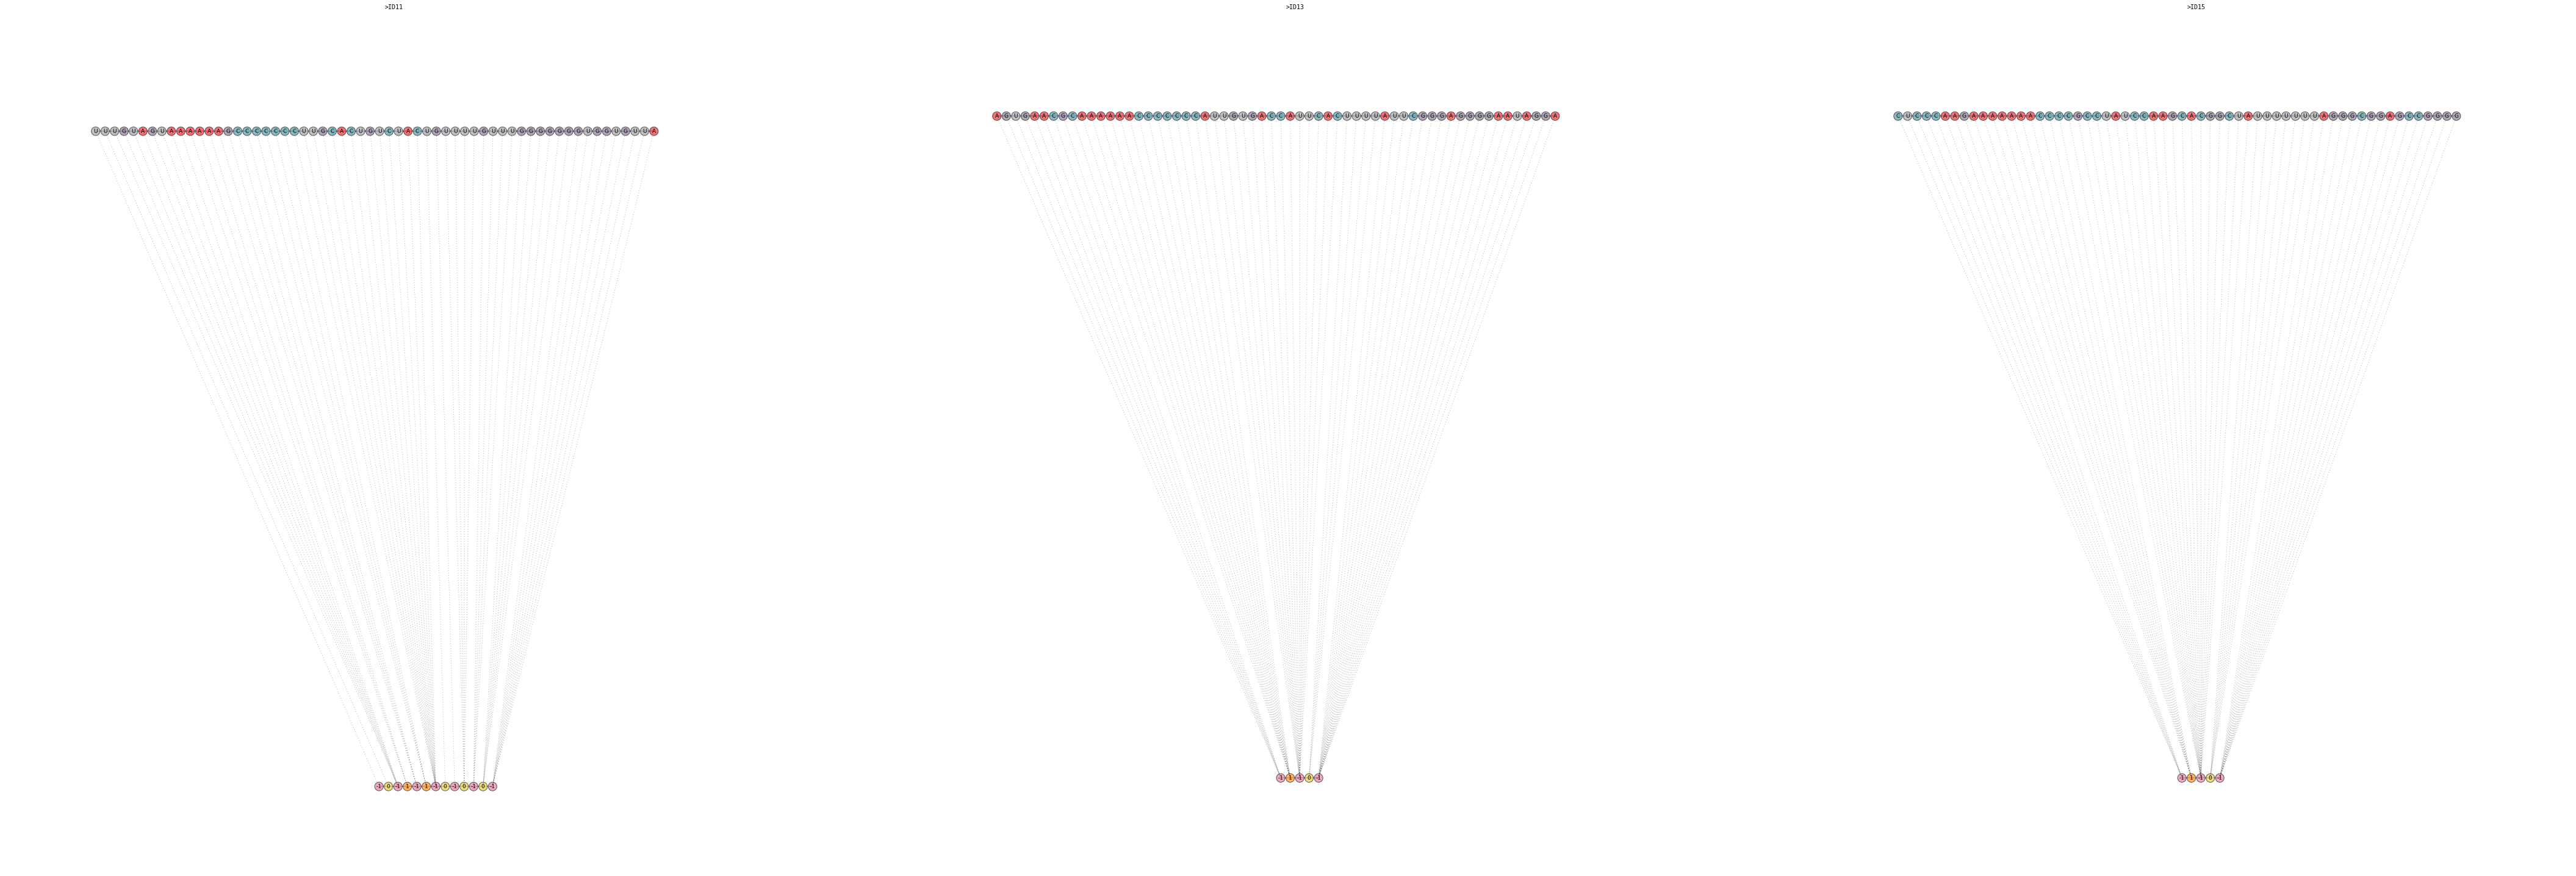

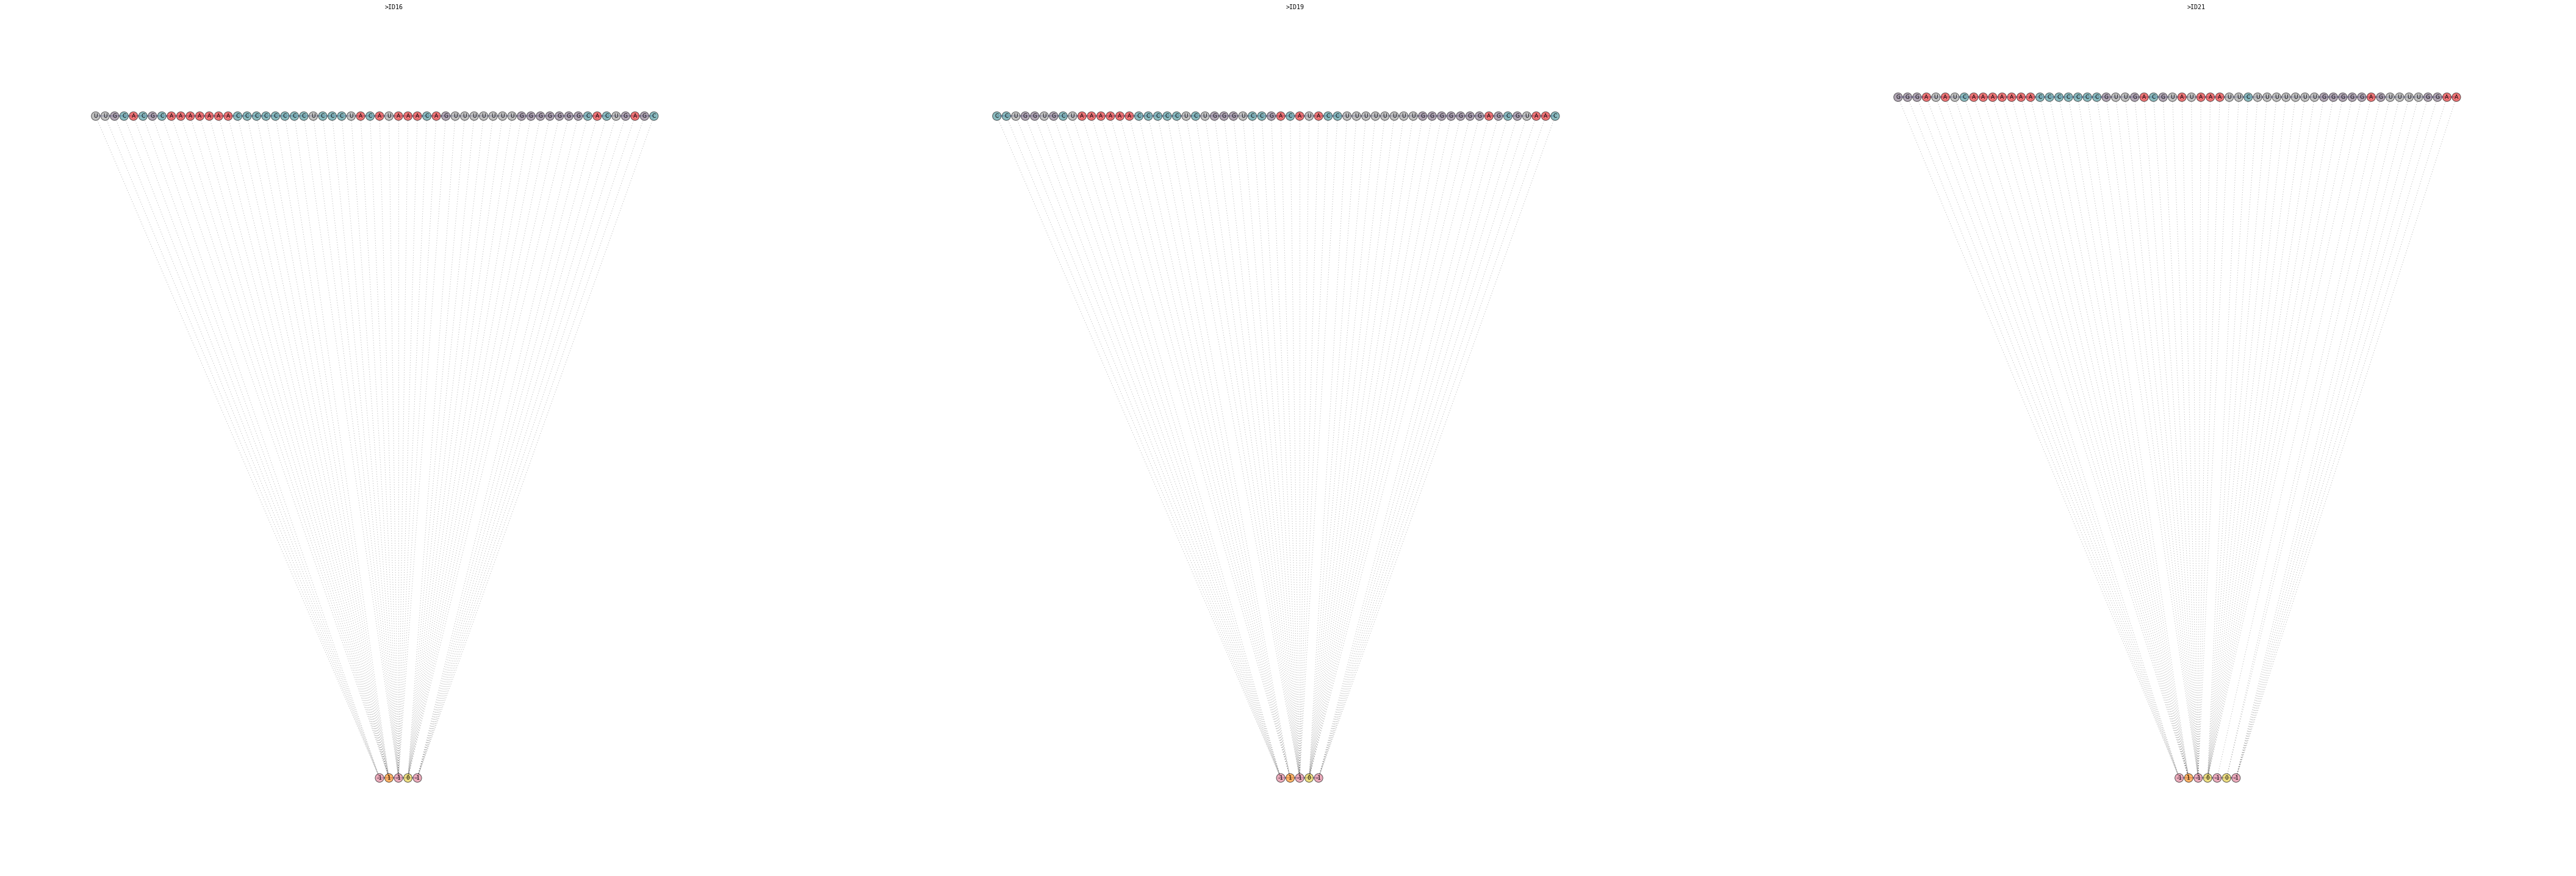

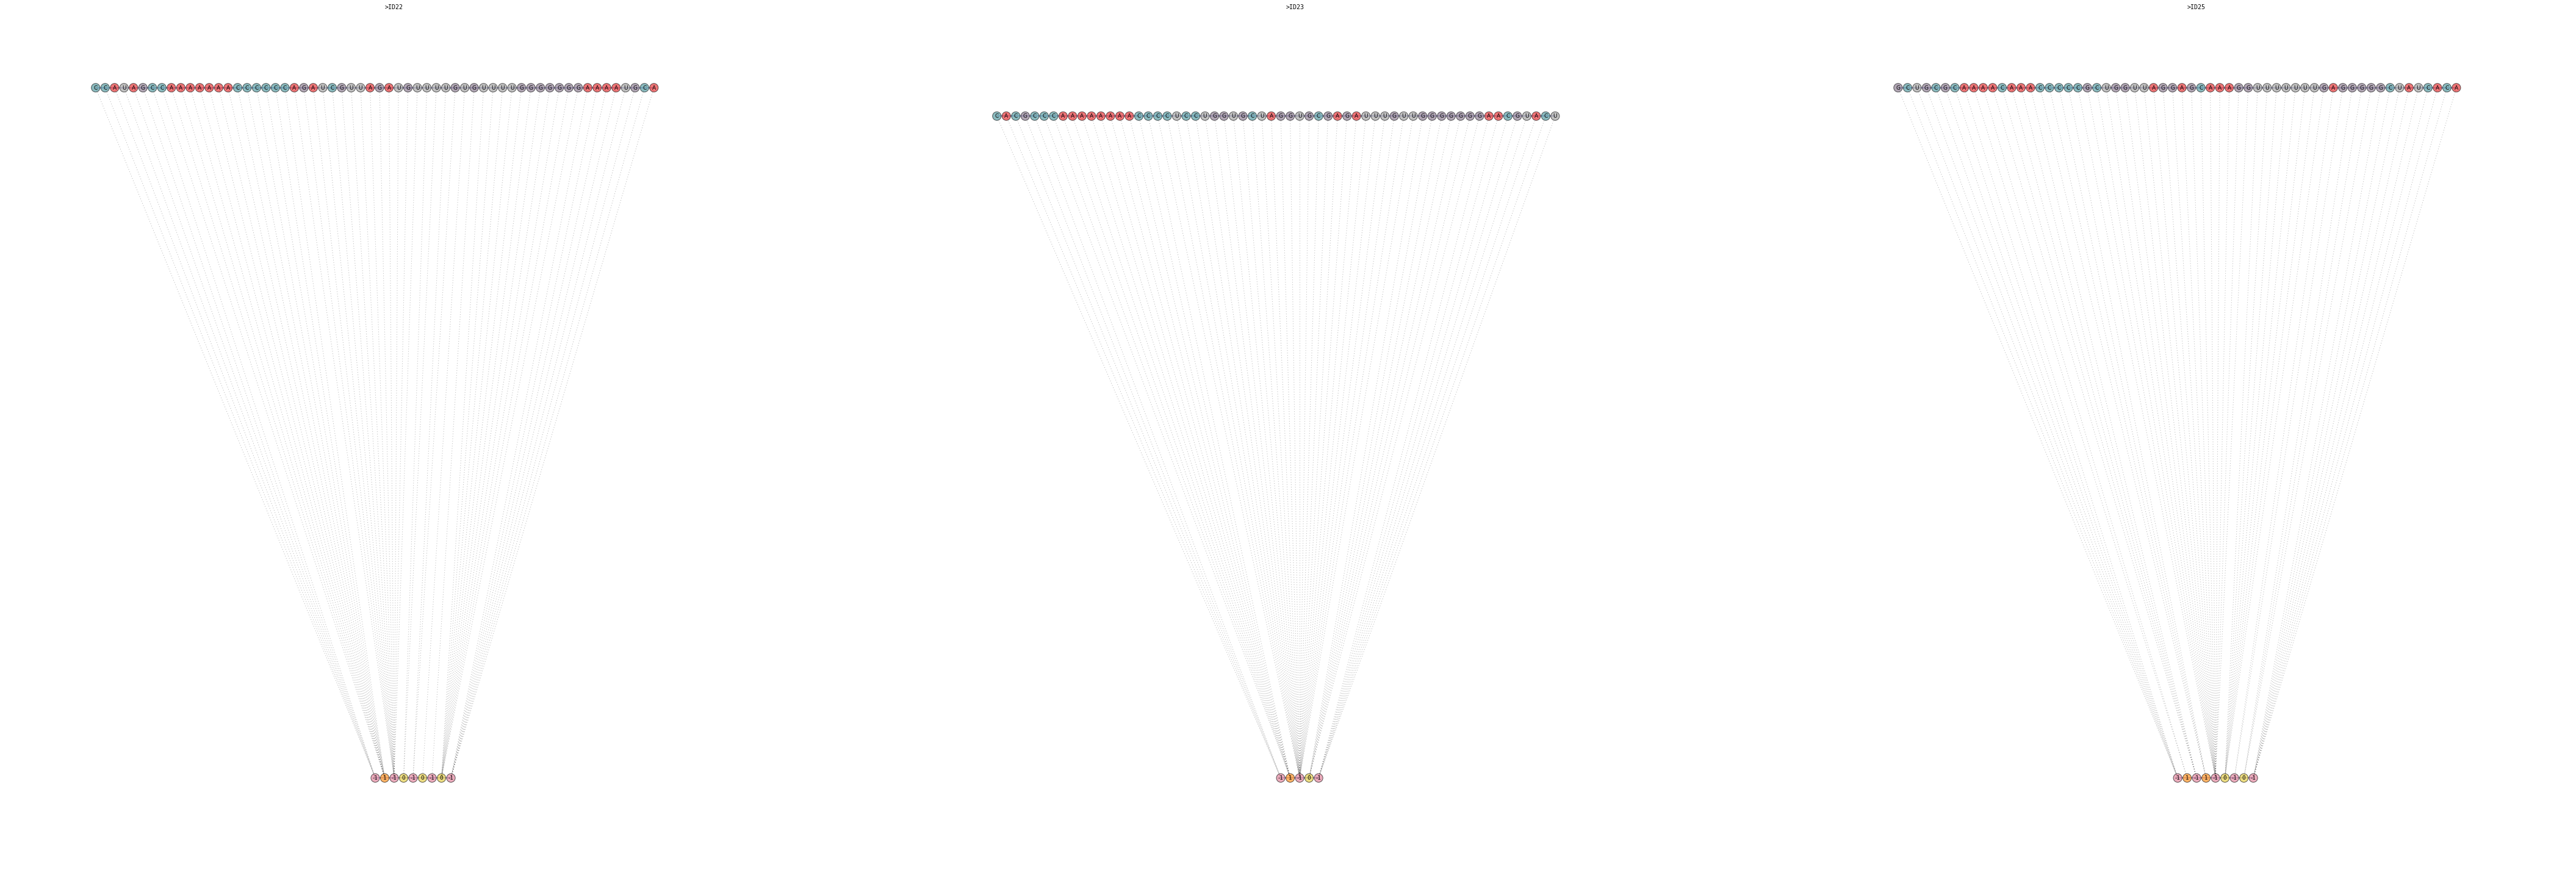

In [192]:
from itertools import islice
from eden.util.display import draw_graph_set
opts.update({'vertex_color':'_label_', 'colormap':'Set1', 'size':25})
draw_graph_set(islice(tgraphs,12), **opts)

---